In [6]:
import networkx
import itertools
import dataclasses
import math
import typing
import matplotlib.pyplot as plt

In [7]:
class Data:
    """
    Data for graph community detection.
    """
    
    @staticmethod
    def __read_graph(path: str):
        return networkx.read_gml(path, label="id")
    
    @staticmethod
    def __read_answer(path: str):
        with open(path) as f:
            answer = {}
            for line in f:
                split = line.split()
                if len(split) < 2:
                    continue
                label = int(split[0])
                group = int(split[1])
                answer.setdefault(group, [])
                answer[group].append(label)
            answer = { tuple(sorted(a)) for a in answer.values() }
            return answer
    
    def __init__(
        self,
        graph_path: str,
        *,
        answer_path: typing.Optional[str] = None,
    ):
        self.graph = Data.__read_graph(graph_path)
        if answer_path is not None:
            self.answer = Data.__read_answer(answer_path)
        else:
            self.answer = None

datas = {
    "karate": Data(
       "./karate/karate.gml",
       answer_path="./karate/classLabelkarate.txt",
    ),
    "football": Data(
        "./football/football.gml",
        answer_path="./football/classLabelfootball.txt",
    ),
    "dolphins": Data(
        "./dolphins/dolphins.gml",
        answer_path="./dolphins/classLabeldolphins.txt",
    ),
    "krebs": Data(
        "./krebs/krebs.gml",
        answer_path="./krebs/classLabelkrebs.txt",
    ),
    
    # data I found
    "lesmis": Data(
        "./student/lesmis.gml",
    ),
    "oa-1": Data(
        "./student/oa-1.gml",
    ),
    "oa-2": Data(
        "./student/oa-2.gml",
    ),
    "oa-3": Data(
        "./student/oa-3.gml",
    ),
    "my-1": Data(
        "./student/my-1.gml",
    ),
    "my-2": Data(
        "./student/my-2.gml",
    ),
}

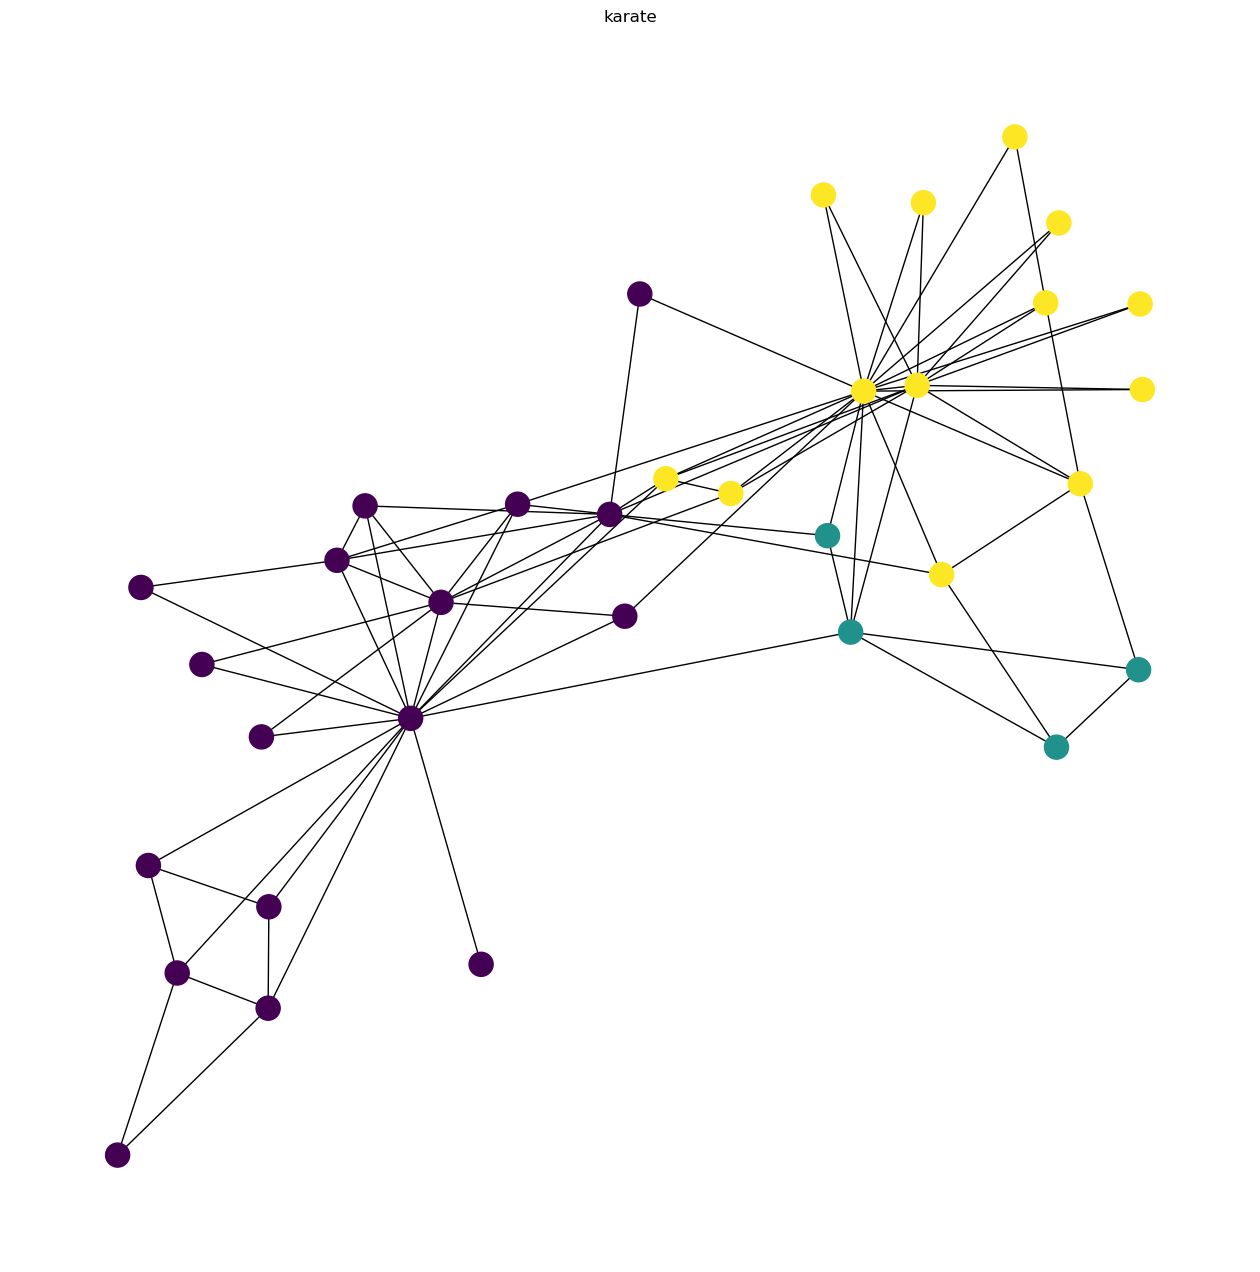

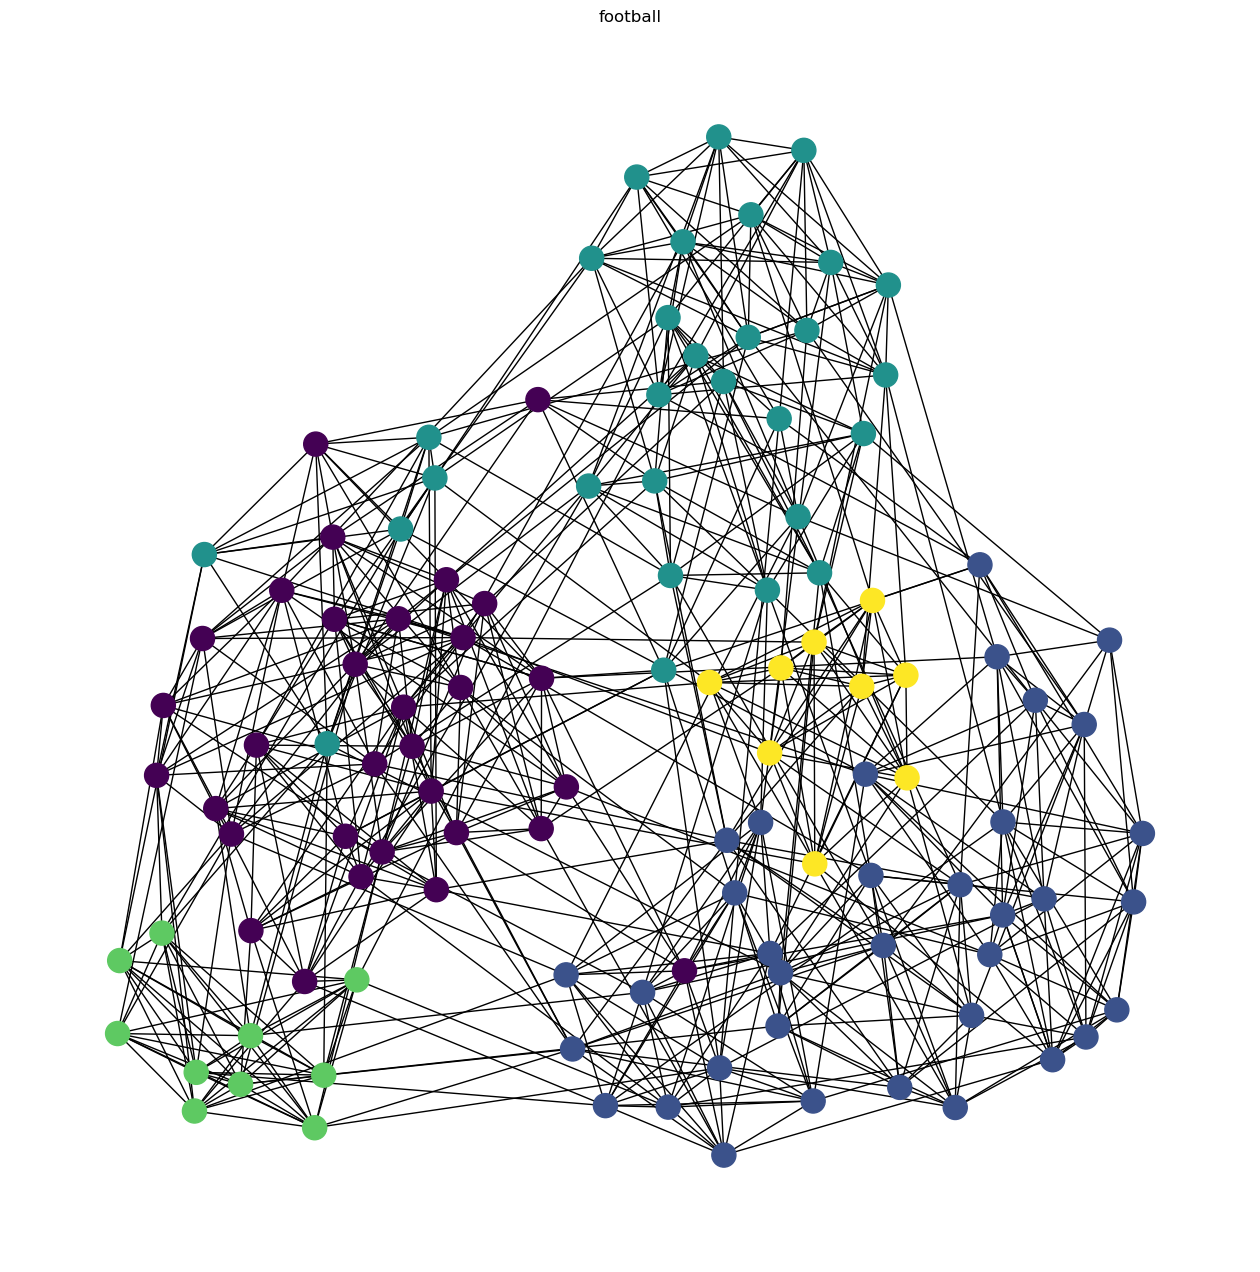

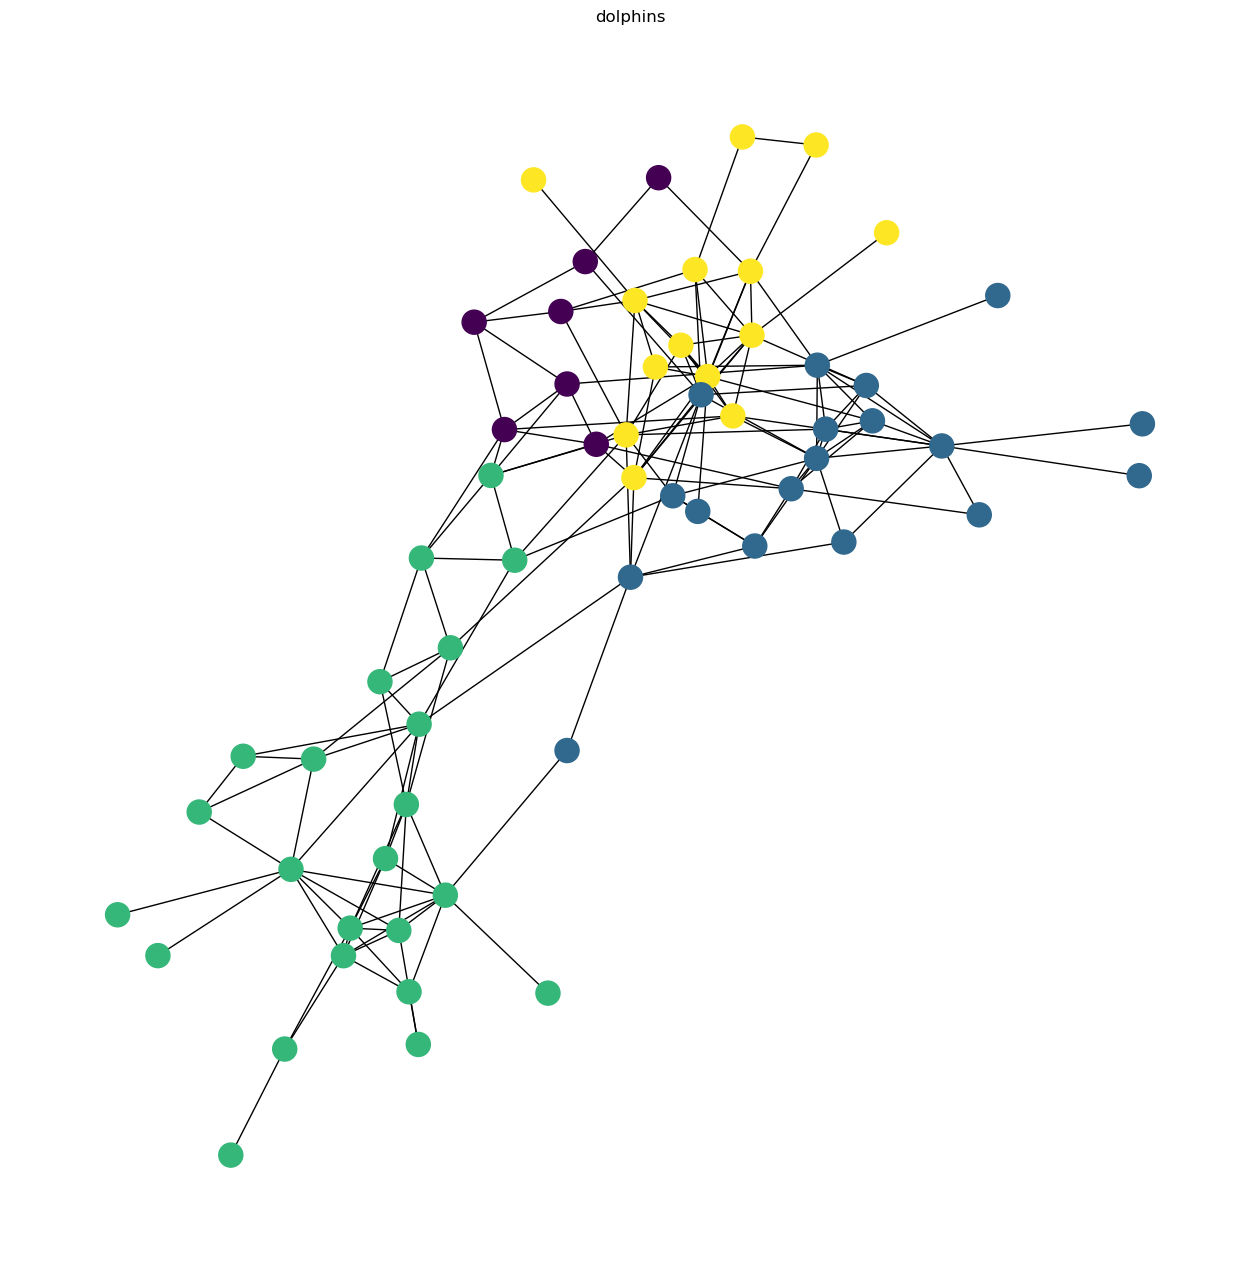

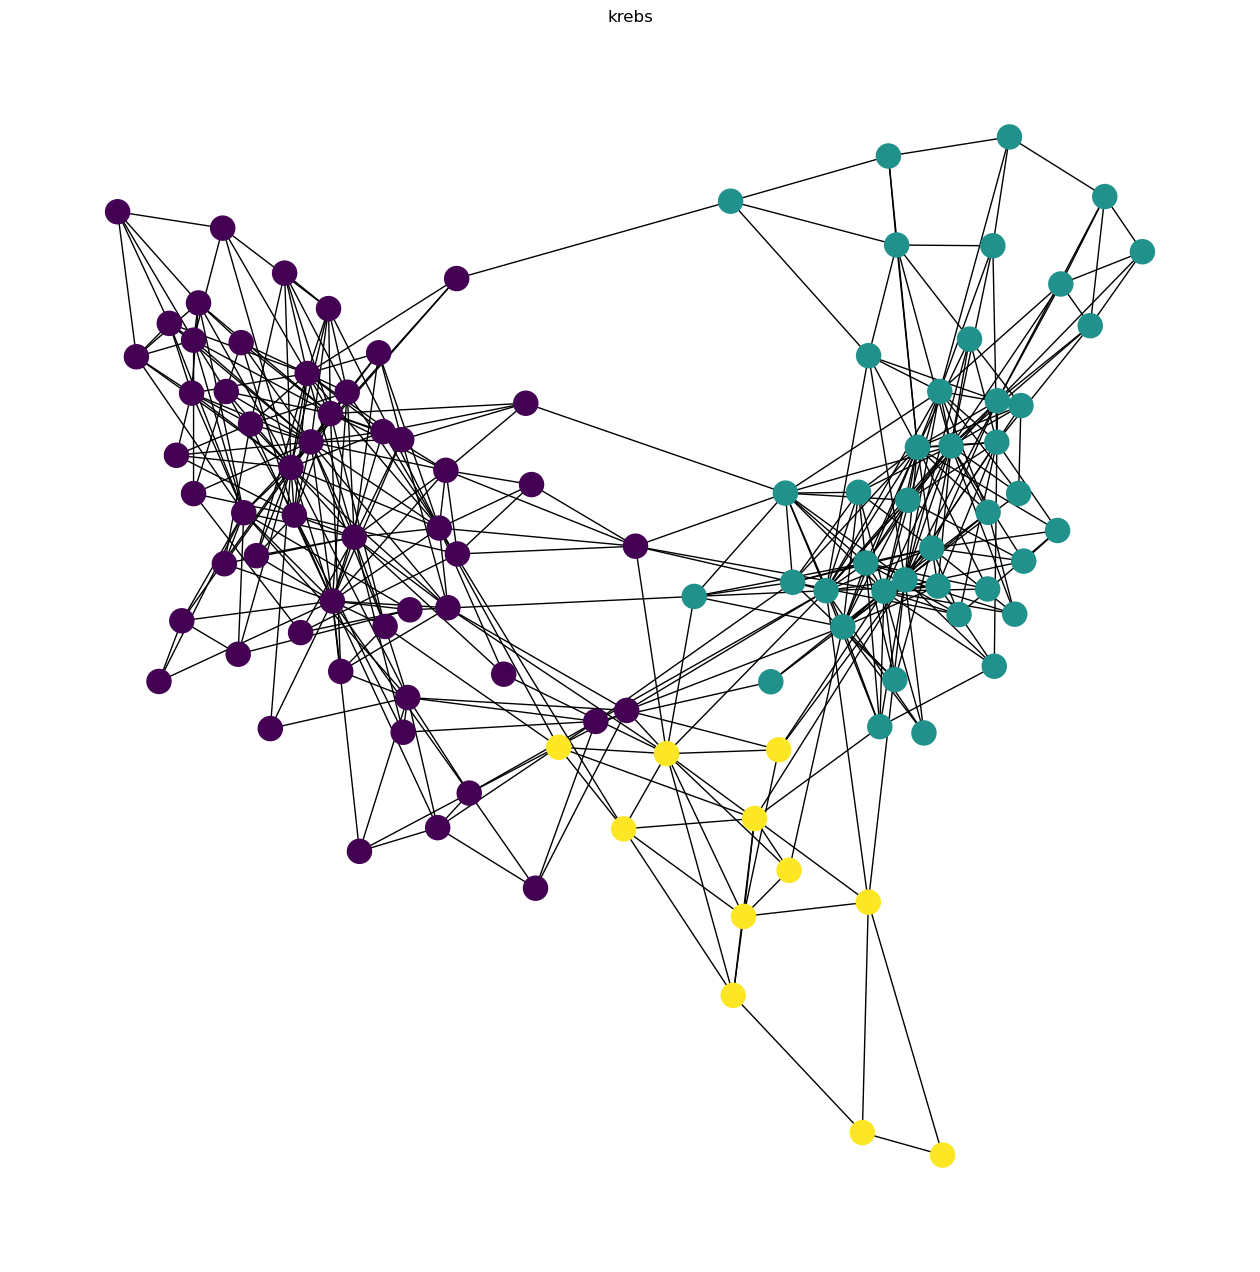

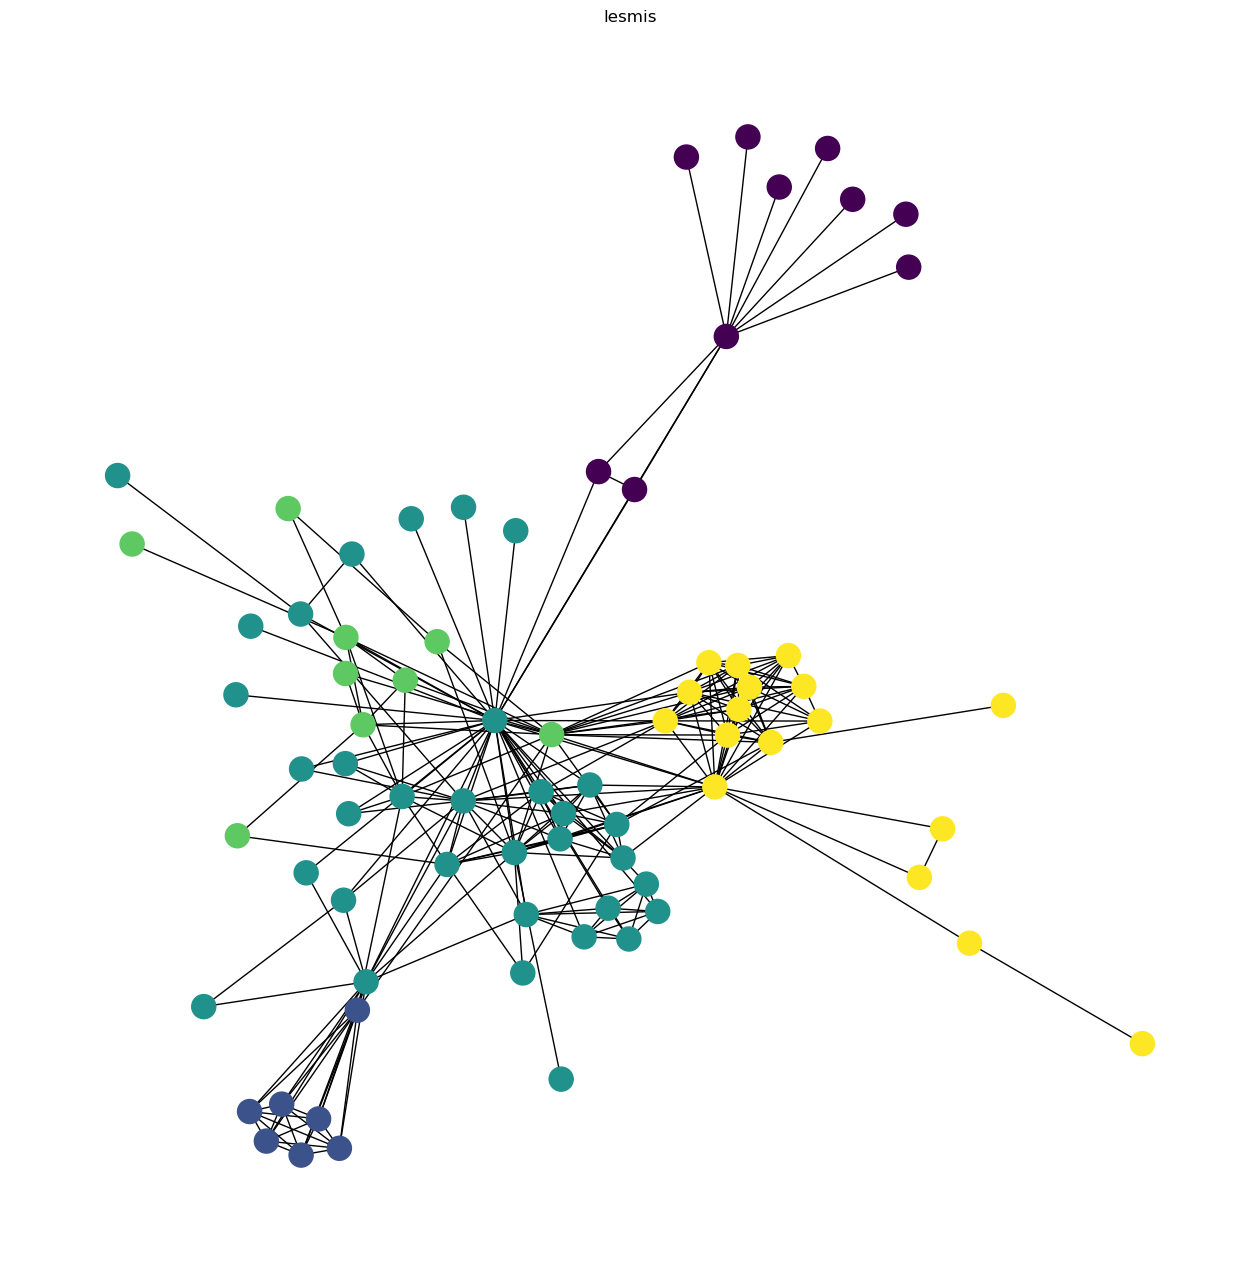

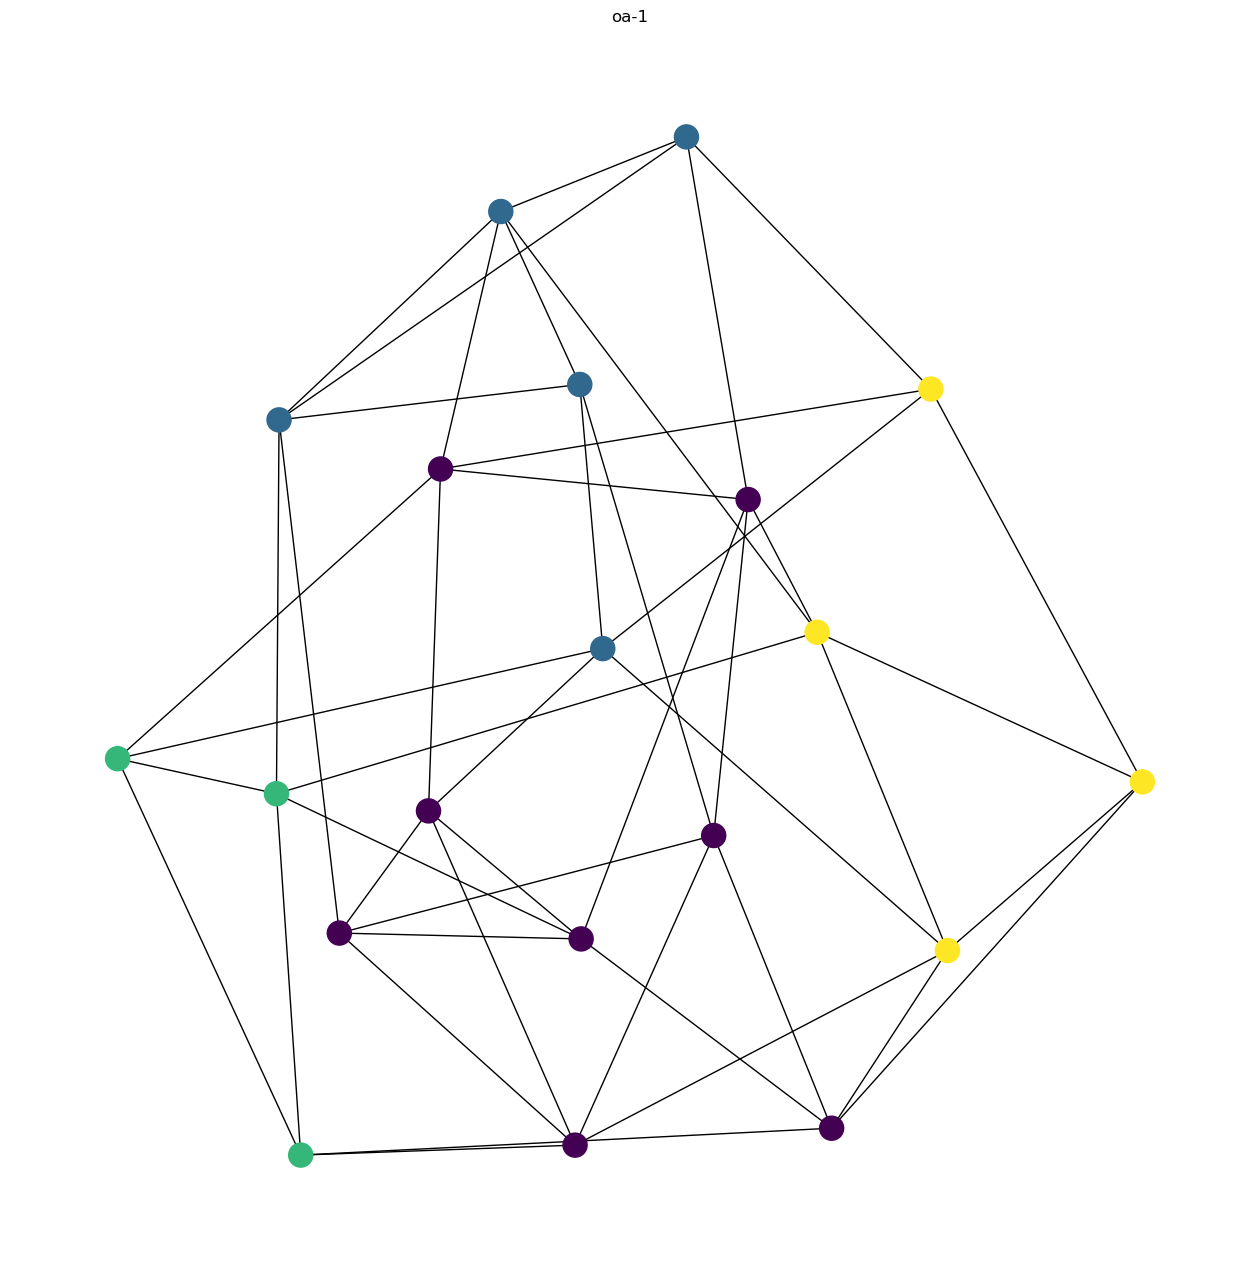

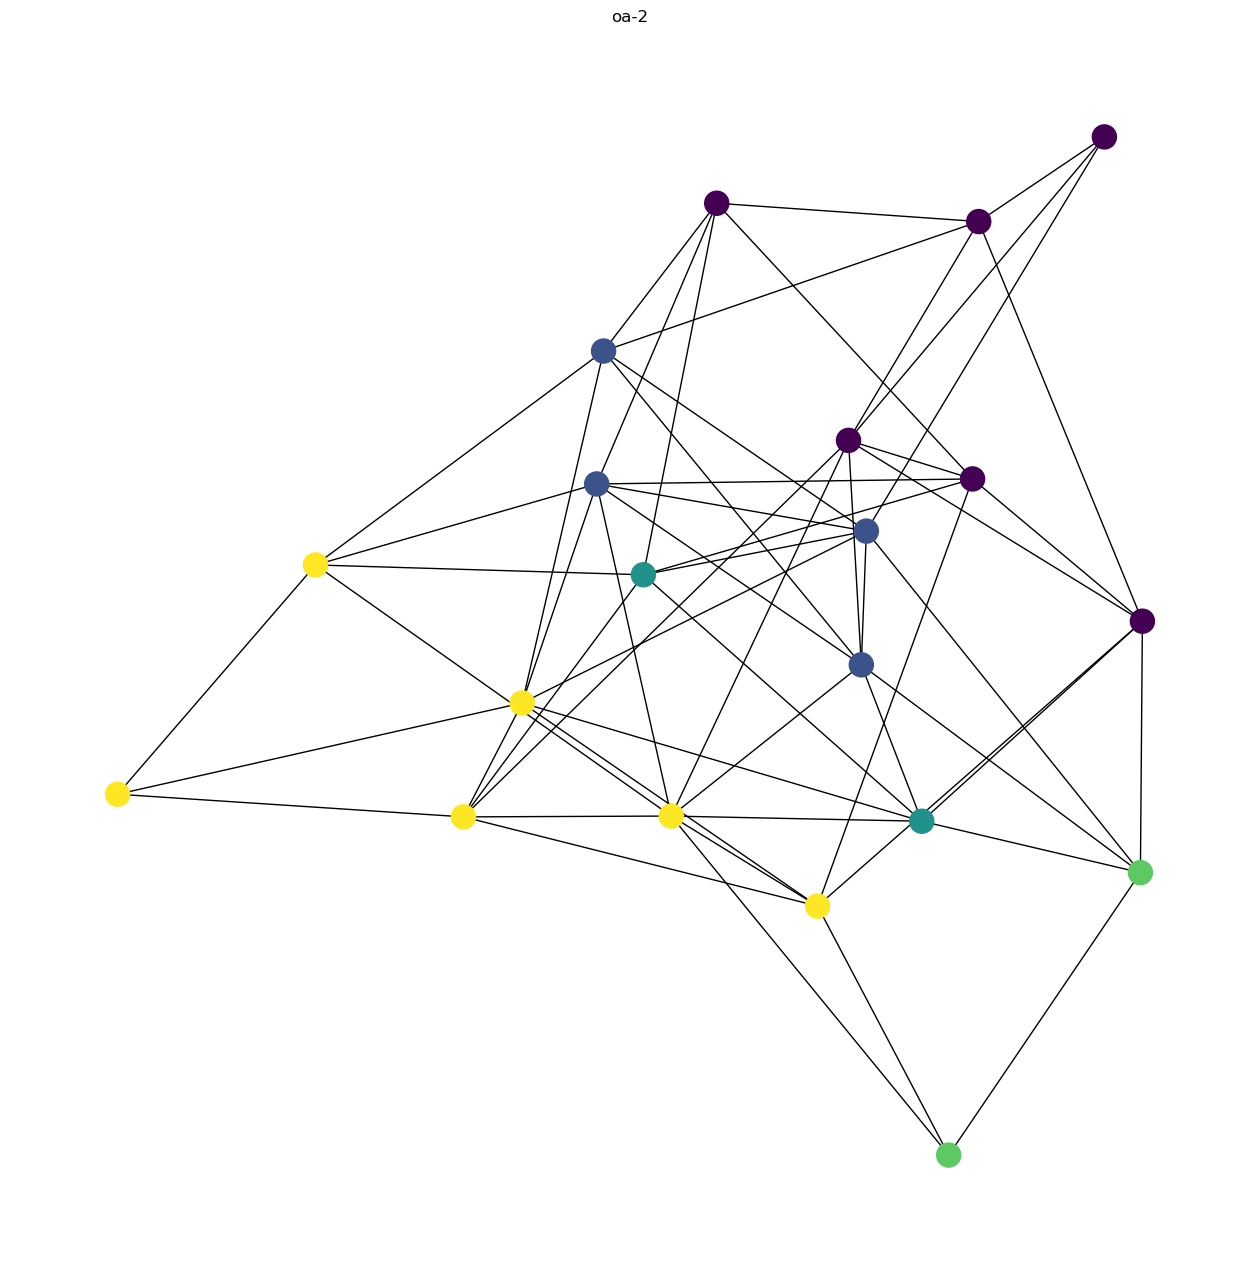

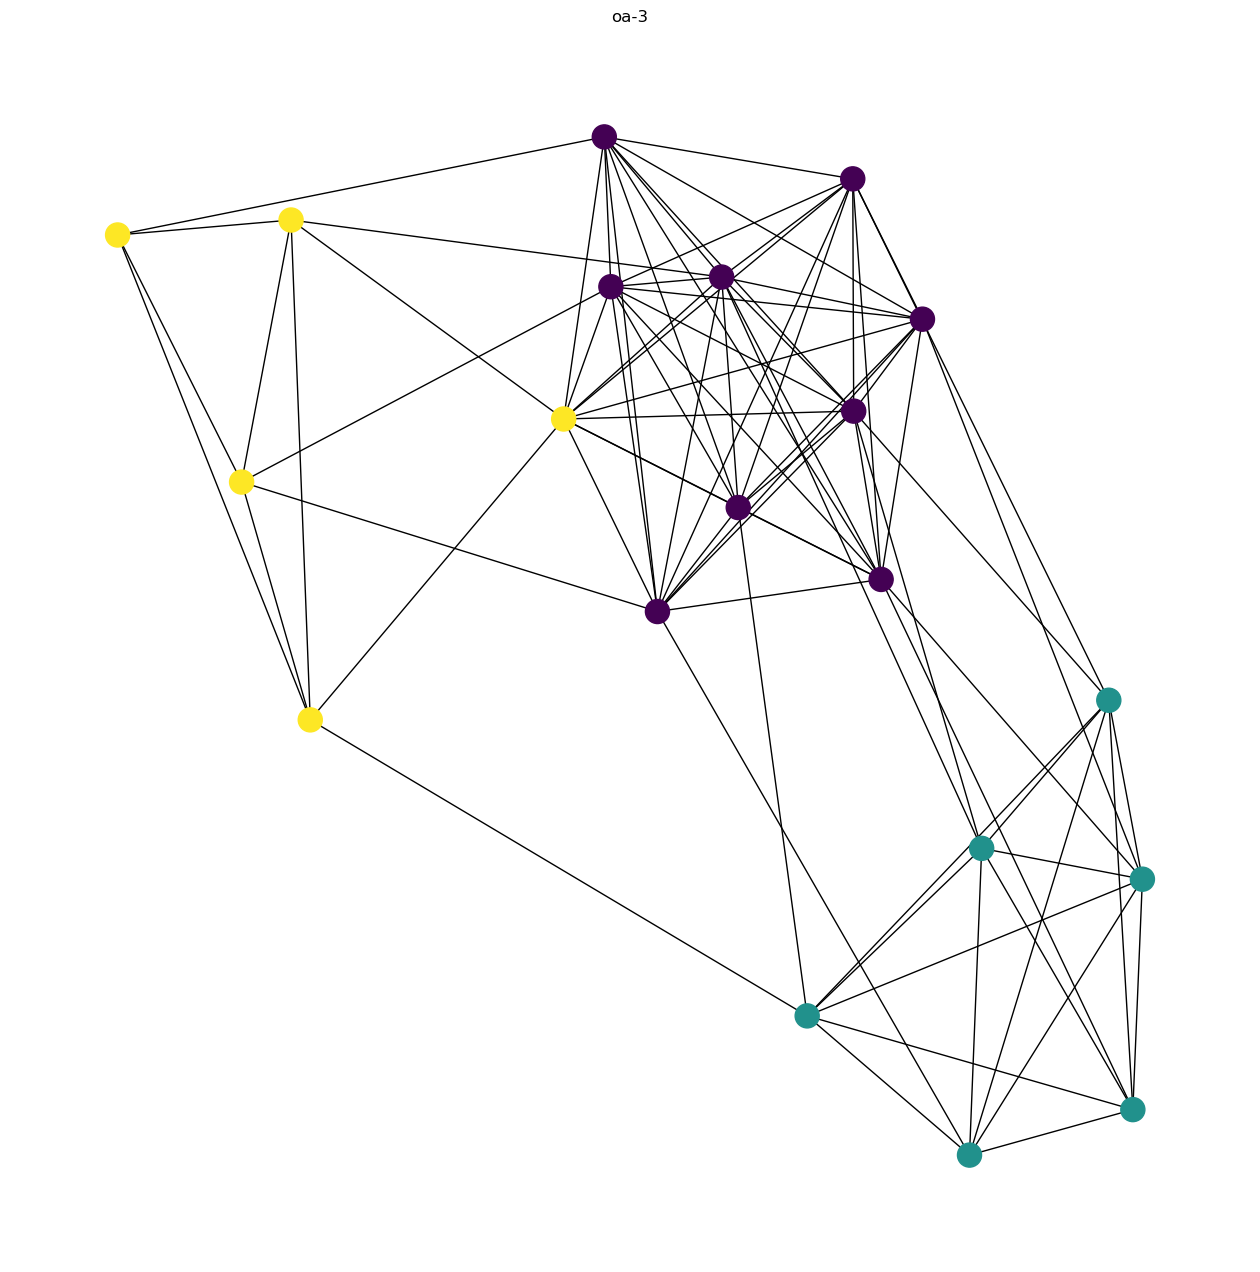

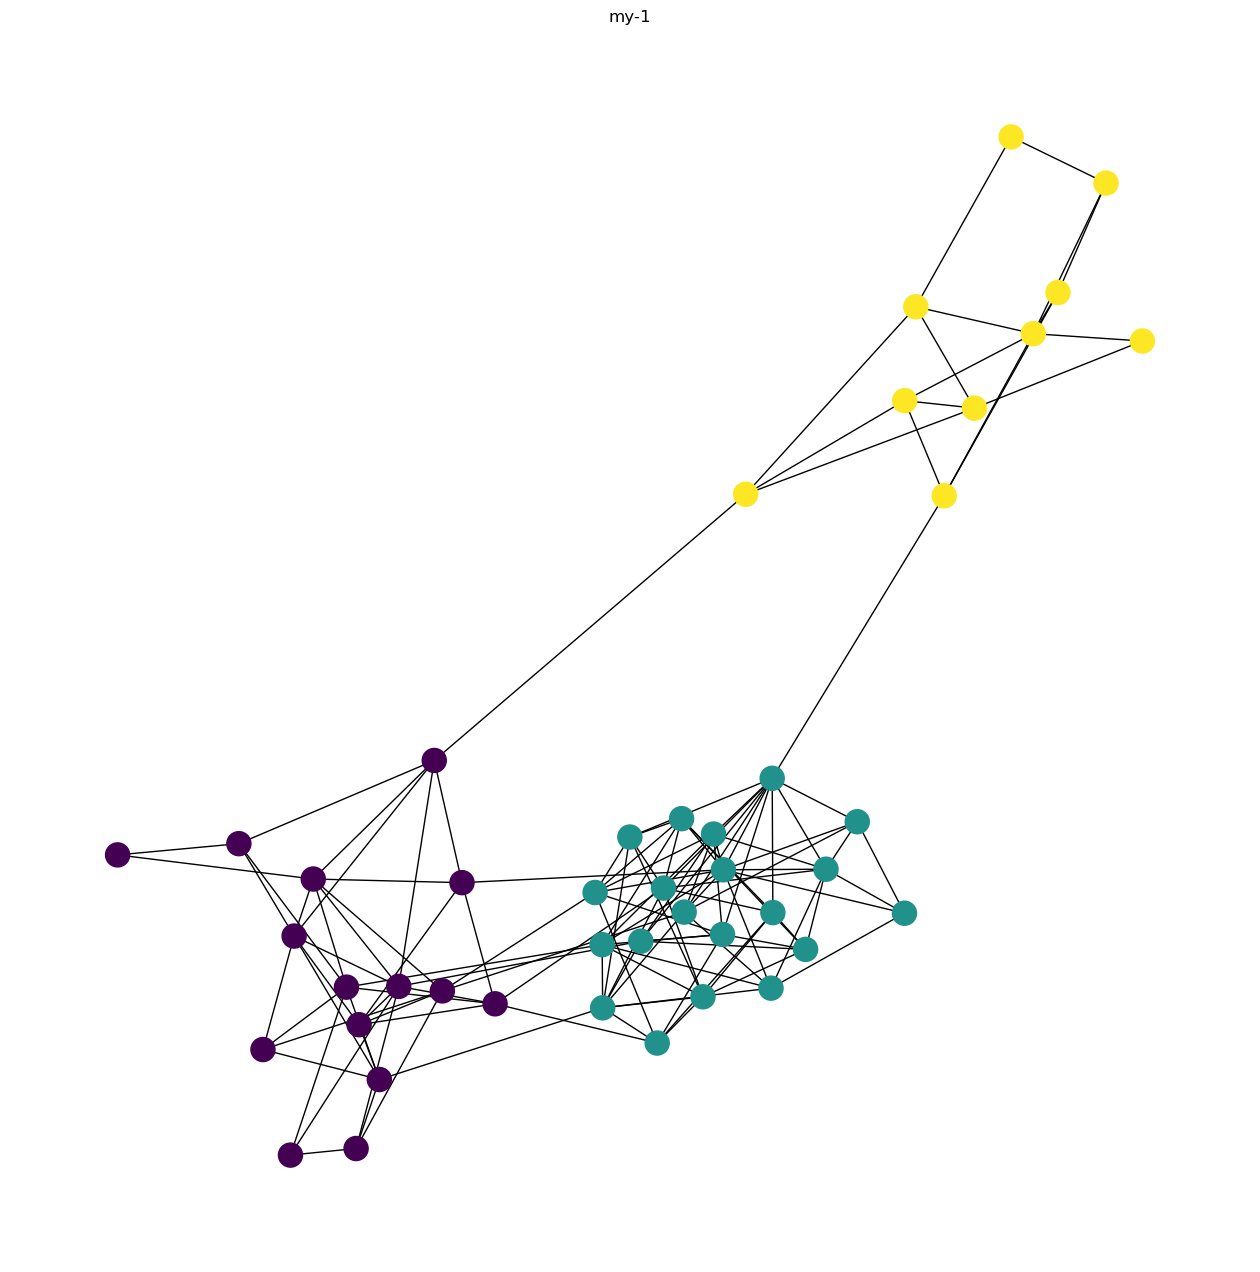

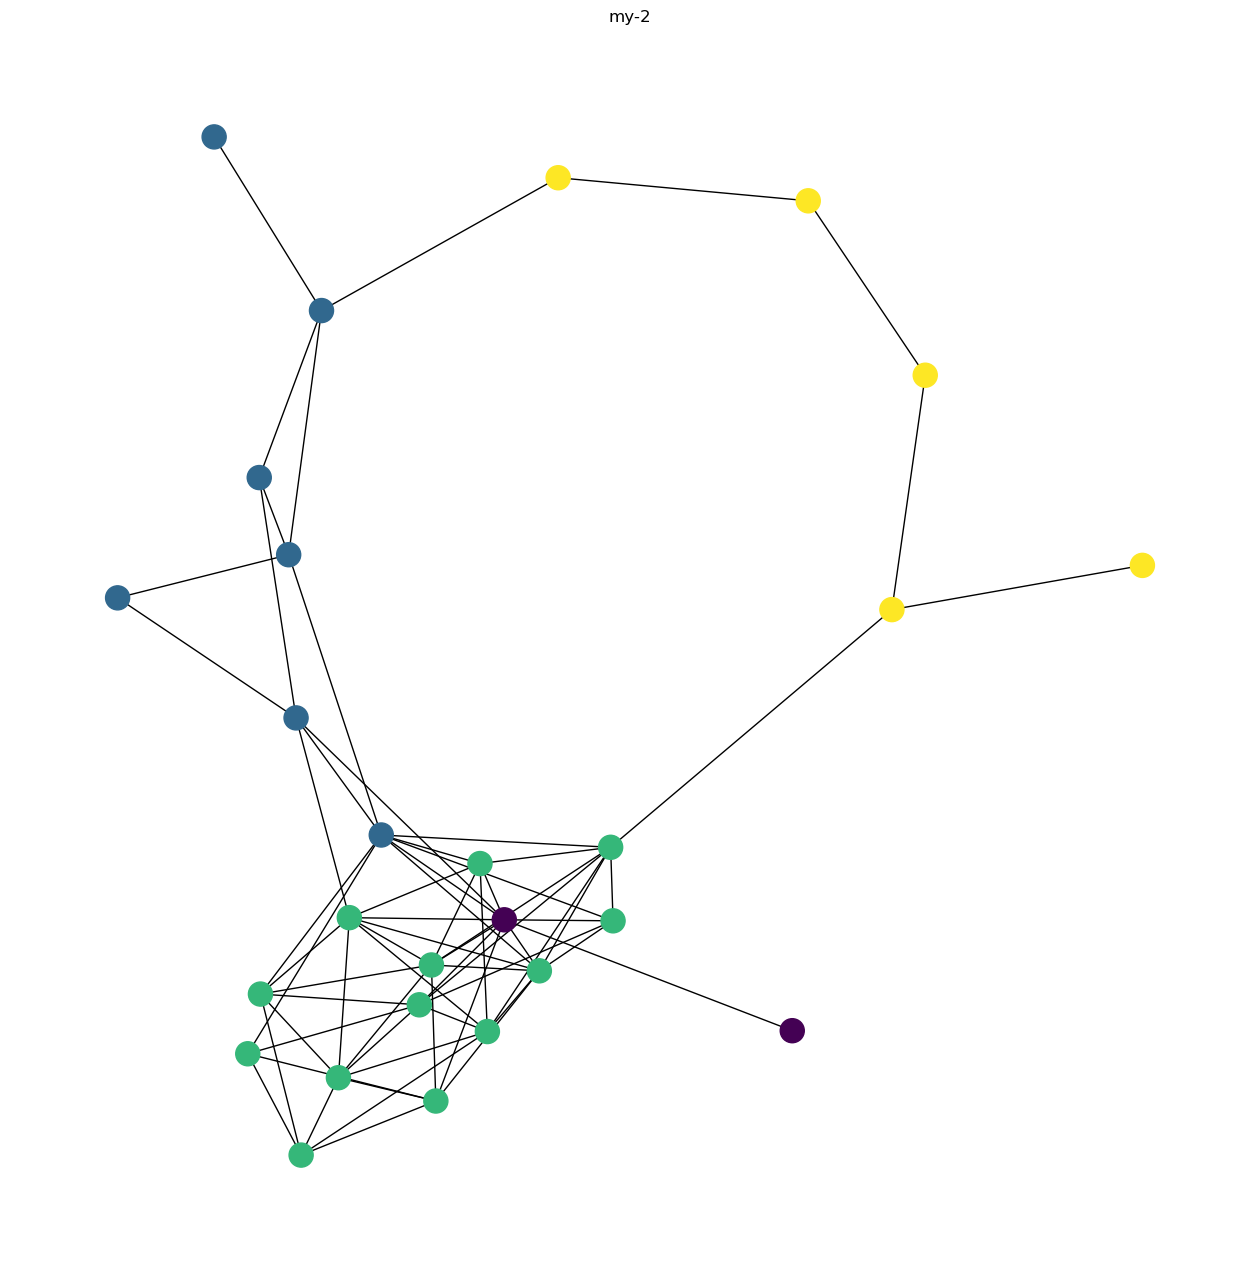

In [27]:
@dataclasses.dataclass(eq=True, frozen=True)
class GreedyStep:
    merged_edge: (int, int)
    modularity: float

class DisjointSet:
    """
    Disjoint set data structure.
    """
    
    def __init__(self, nodes):
        self.__inner = { a:a for a in nodes }
    
    def root(self, a):
        if not a in self.__inner:
            self.__inner[a] = a
        
        if a != self.__inner[a]:
            self.__inner[a] = self.root(self.__inner[a])
        
        return self.__inner[a]
    
    def union(self, a, b):
        """
        Unite the sets which contain elements a and b.
        """
        a = self.root(a)
        b = self.root(b)
        self.__inner[b] = a
    
    def find(self, a, b):
        """
        Check whether elements a and b are in the same set.
        """
        return self.root(a) == self.root(b)
    
    def roots(self):
        """
        Return list of all the roots.
        """
        return [a for a in self.__inner if self.__inner[a] == a]
    
    def sets_with_root(self):
        """
        Return a dictionary where the values are all the sets,
        and the keys are the sets' roots.
        """
        result = {}
        for a in self.__inner:
            result.setdefault(self.root(a), []).append(a)
        return result

def modularity_fn(ds: DisjointSet, graph: networkx.classes.graph.Graph): 
    M = 2 * len(graph.edges())
    Q = 0.0
    for i in graph.nodes():
        for j in graph.nodes():
            if ds.find(i, j):
               Q += (graph.has_edge(i, j) - graph.degree(i) * graph.degree(j) / M)
    return Q * 1 / M
    
def solve(graph: networkx.classes.graph.Graph):
    """
    Returns a list of steps performed while trying to greedily
    optimize the modularity of the input graph.
    """
    
    disjoint_set = DisjointSet(graph.nodes)
    e = {}
    a = { node:0 for node in graph.nodes() }
    
    for edge_a, edge_b in graph.edges():
        a[edge_a] += 1
        a[edge_b] += 1
        e[(edge_a, edge_b)] = e.get((edge_a, edge_b), 0) + 1
        # e[(edge_a, edge_b)] = 1
        assert (edge_b, edge_a) not in e
    a = { key:value/(len(graph.edges())*2) for key,value in a.items() }
    e = { key:value/(len(graph.edges())*1) for key,value in e.items() }
    
    steps = []
    
    modularity = 0
    for key, value in a.items():
        modularity += e.get((key, key), 0) - value**2
    
    remaining_edges = list(graph.edges())
    remaining_nodes = set(graph.nodes())
    while True:
        chosen_edge = None
        chosen_edge_delta_modularity = None
        for edge_a, edge_b in remaining_edges:
            assert ((edge_a, edge_b) in e) != ((edge_b, edge_a) in e)
            
            if not (edge_a, edge_b) in e:
                edge_a, edge_b = edge_b, edge_a
            e_ab = e[(edge_a, edge_b)]
            
            # print(delta_modularity)
            delta_modularity = (e_ab - a[edge_a]*a[edge_b])
            # delta_modularity = e_ab - e_ab**2 - 2*a[edge_a]*a[edge_b] + 2*a[edge_a]*e_ab + 2*a[edge_b]*e_ab
            
            if chosen_edge is None or delta_modularity > chosen_edge_delta_modularity:
                chosen_edge = (edge_a, edge_b)
                chosen_edge_delta_modularity = delta_modularity
                # print(e_ab,  a[edge_a]*a[edge_b])
        
        if chosen_edge is None:
            break
        
        modularity += chosen_edge_delta_modularity
        
        steps.append(GreedyStep(chosen_edge, modularity))
        
        chosen_edge_a, chosen_edge_b = chosen_edge
        del a[chosen_edge_a]
        del a[chosen_edge_b]
        disjoint_set.union(chosen_edge_a, chosen_edge_b)
        root = disjoint_set.root(chosen_edge_a)
        a[root] = 0
        e_union = {}
        for edge_a, edge_b in itertools.chain(
            itertools.product([chosen_edge_a, chosen_edge_b], remaining_nodes),
            itertools.product(remaining_nodes, [chosen_edge_a, chosen_edge_b]),
        ):
            e_value = e.pop((edge_a, edge_b), None)
            if e_value is None:
                continue
            
            if edge_a in chosen_edge and edge_b in chosen_edge:
                e_union_dest = root
            else:
                if edge_a in chosen_edge:
                    e_union_dest = edge_b
                else:
                    e_union_dest = edge_a
            
            e_union[e_union_dest] = e_union.get(e_union_dest, 0) + e_value
            a[root] += e_value
        
        remaining_nodes.remove(chosen_edge_a)
        remaining_nodes.remove(chosen_edge_b)
        remaining_nodes.add(root)
        
        for e_node, e_value in e_union.items():
            e[(root, e_node)] = e_value
        
        remaining_edges = [
            (disjoint_set.root(edge_a), disjoint_set.root(edge_b))
            for edge_a, edge_b in remaining_edges
            if not disjoint_set.find(edge_a, edge_b)
        ]
    
    return steps

for name, data in datas.items():
    steps = solve(data.graph)
    
    best_step = max(steps, key = lambda step: step.modularity)
    best_step_index = steps.index(best_step)

    ds = DisjointSet(data.graph.nodes())
    for step in steps[0:best_step_index+1]:
        ds.union(step.merged_edge[0], step.merged_edge[1])

    roots = ds.roots()
    root_to_color = { a:i for i, a in enumerate(roots) }
    colors = [ root_to_color[ds.root(a)] for a in data.graph.nodes() ]
    
    # sets = ds.sets_with_root()
    # answer = { tuple(value) for value in sets.values() }
    
    # print(data.answer)
    # print(answer)
    
    plt.figure(figsize=(16, 16))
    plt.title(name)
    networkx.draw(data.graph, node_color=colors)
    
#     if data.answer is not None:
#         colors = [None] * len(data.graph.nodes())
#         for i, module in enumerate(data.answer):
#             for node in module:
#                 colors[node-1] = i

#         plt.figure(figsize=(16, 16))
#         plt.title(name)
#         networkx.draw(data.graph, node_color=colors)